In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import shutil
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
import pathlib
from sklearn.metrics import confusion_matrix
import functools

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
tf.config.list_physical_devices('GPU')
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Sat Apr 24 20:25:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+------

In [ ]:
data_dir = pathlib.Path('/content/drive/MyDrive/Fire_recogntion_data/fire_test') 

In [ ]:
# count the number of fire labels and non fire labels. 
def file_count(path):
  file_count = 0
  dirs = os.listdir(path)
  for dir in dirs:
    dir2 = path.joinpath(dir)  
    if os.path.isdir(dir2):
      file_count += len(os.listdir(dir2))

  return file_count


def learning_plot(record):
  """Function to plot the metrics"""
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))
  train_acc = record.history['accuracy']
  val_acc = record.history['val_accuracy']
  train_loss = record.history['loss']
  val_loss = record.history['val_loss']
  epoch = range(len(train_acc))
  ax1.plot(epoch, train_acc, label='Training Accuracy')
  ax2.plot(epoch, train_loss, label='Training Loss')
  ax1.plot(epoch, val_acc, label='Validation Accuracy')
  ax2.plot(epoch, val_loss, label='Validation Loss')
  ax1.set_xlabel('Epoch')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Loss')
  ax1.set_ylabel('Accuracy')
  ax1.legend(loc = 'upper right')
  ax2.legend(loc = 'upper right')
  ax1.set_title('Learning curve of Accuracy')
  ax2.set_title('Learning curve of Loss')

# Preprocessing

### Balance the imbalanced data by up sampling the minority class

1. Copy the fire images to the size of nonfire images (I made two copies here, the original code was to repeat fire images and do image augumentation on duplicates, but RAM ran out, so I had to copy fire images on device and then read it from directory)
2. Apply image augmentation to the data 
3. Append the copied data to the original images
4. Batch data and split to test and training and validation

In [ ]:
# check label distribution
fire_image_count = file_count(data_dir/'fire')
nonfire_image_count = file_count(data_dir/'no_fire')
ratio = fire_image_count / nonfire_image_count
print('The number of fire images is', fire_image_count)
print('The number of non fire images is', nonfire_image_count)
print('The ratio of fire image to non-fire image is', round(ratio, 2))

The number of fire images is 1232
The number of non fire images is 1212
The ratio of fire image to non-fire image is 1.02


### Load images from directory 

1. Resize images to height 640 and width 480 since images size ranging from (320, 240) to (1920, 1080)

2. Unbatch data since we need to combind two labels after

3. label data, fire with 1, non fire with 0

In [ ]:
# Image augmentation to create more fire images
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation((-0.4, 0.4)),
  #layers.experimental.preprocessing.RandomContrast(0.3)
])

# make a label dictionary for label names
label_dict = {0: 'no_fire', 1: 'fire'}
label_dict

{0: 'no_fire', 1: 'fire'}

In [ ]:
img_height = 640
img_width = 480
batch_size = 32

# load fire data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir, 
  seed=123, label_mode = 'int', class_names = ['no_fire', 'fire'],
  image_size=(img_height, img_width),
  batch_size = batch_size, validation_split = 0.2, subset = 'training'
  ).map(lambda x, y: (data_augmentation(x/255.), y) ).cache().prefetch(2)
train_size = train_ds.cardinality().numpy()
print('Train batches', train_size)


test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir, 
  seed=123, label_mode = 'int', class_names = ['no_fire', 'fire'],
  image_size=(img_height, img_width),
  batch_size = batch_size, validation_split = 0.2, subset = 'validation', 
  ).map(lambda x, y: (data_augmentation(x/255.), y) ).cache().prefetch(2)
test_size = test_ds.cardinality().numpy()
print('Test batches', test_size)

Found 2444 files belonging to 2 classes.
Using 1956 files for training.
Train batches 62
Found 2444 files belonging to 2 classes.
Using 488 files for validation.
Test batches 16


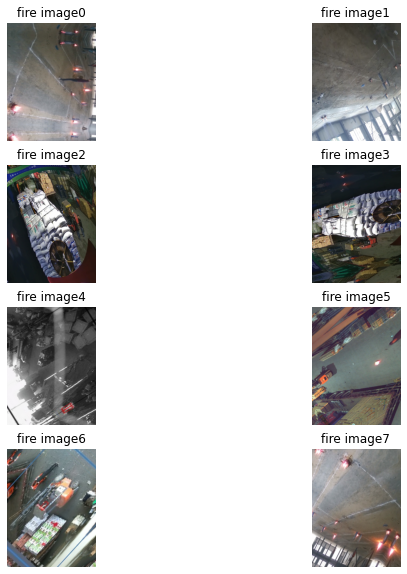

In [ ]:
# Check if images loaded correctly
plt.figure(figsize=(10, 10))
for images, label in train_ds.take(1).as_numpy_iterator():
  for i in range(8):
    ax = plt.subplot(4, 2, i + 1)
    ax.imshow(images[i].squeeze(), vmin=0., vmax=1.,)
    plt.title('fire image' + str(i))
    plt.axis("off")

## Define a Convolution autoencoder to learn high level features

1. Not too deep, 4 convolutional layers
2. BatchNormalization
3. No pooling and dense layers

In [ ]:
# Encoder 

n_filters = 12 # base number of convolutional filters

def make_encoder():
  """5 convolution layers with increasing filters, use batch normalization"""
  Conv2D = functools.partial(layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = layers.BatchNormalization
  Flatten = layers.Flatten
  Dense = functools.partial(layers.Dense, activation='relu')
  model = tf.keras.Sequential([
    layers.Input(shape=(640, 480, 3), name='input'),
    Conv2D(filters=1*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),
    
    Conv2D(filters=2*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3,  strides=2, name='48filter_layer'),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=3,  strides=2, name='72filter_layer'),
    BatchNormalization(),

    Conv2D(filters=8*n_filters, kernel_size=3,  strides=2, name='96filter_layer'),
    BatchNormalization(),
  ])
  return model

In [ ]:
# define a decoder

def make_decoder():
  """Reverse the convolution process by Conv2DTranspose, symmetric to the encoder"""
  BatchNormalization = layers.BatchNormalization
  Conv2DTranspose = functools.partial(layers.Conv2DTranspose, padding='same', activation='relu')
  Dense = functools.partial(layers.Dense, activation='relu')
  # 4x4 feature maps (with 6N occurances)
  decoder = tf.keras.Sequential([
    # Transform to pre-convolutional generation
    # Upscaling convolutions (inverse of encoder)
    Conv2DTranspose(filters=6*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),
    Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),
    Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),
    Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),
    Conv2DTranspose(filters=3, kernel_size=3,  strides=2, activation='sigmoid'),
  ])

  return decoder

### Define Autoencoder and prepare for training by using training data without lables

In [ ]:
class AUTOENCODER(keras.Model):
  def __init__(self):
    super(AUTOENCODER, self).__init__()
    self.encoder = make_encoder()
    self.decoder = make_decoder()
  
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [ ]:
con_encoder = AUTOENCODER()
con_encoder.encoder.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 320, 240, 12)      912       
_________________________________________________________________
batch_normalization_89 (Batc (None, 320, 240, 12)      48        
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 160, 120, 24)      7224      
_________________________________________________________________
batch_normalization_90 (Batc (None, 160, 120, 24)      96        
_________________________________________________________________
48filter_layer (Conv2D)      (None, 80, 60, 48)        10416     
_________________________________________________________________
batch_normalization_91 (Batc (None, 80, 60, 48)        192       
_________________________________________________________________
72filter_layer (Conv2D)      (None, 40, 30, 72)      

In [ ]:
# Compile Model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
con_encoder.compile(loss=losses.MSE, optimizer=optimizer)
earlystopping = keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

In [ ]:
# data = np.stack(list(train_ds.map(lambda x, y: x).unbatch()))
# print('Training data shape:', data.shape)

Training data shape: (1956, 640, 480, 3)


In [ ]:
con_encoder.decoder.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_47 (Conv2DT (None, 40, 30, 72)        62280     
_________________________________________________________________
batch_normalization_85 (Batc (None, 40, 30, 72)        288       
_________________________________________________________________
conv2d_transpose_48 (Conv2DT (None, 80, 60, 48)        31152     
_________________________________________________________________
batch_normalization_86 (Batc (None, 80, 60, 48)        192       
_________________________________________________________________
conv2d_transpose_49 (Conv2DT (None, 160, 120, 24)      10392     
_________________________________________________________________
batch_normalization_87 (Batc (None, 160, 120, 24)      96        
_________________________________________________________________
conv2d_transpose_50 (Conv2DT (None, 320, 240, 12)    

In [ ]:
con_encoder.fit(data, data, epochs=150, callbacks=earlystopping, batch_size=64)

Epoch 1/150
31/31 [==============================] - 12s 352ms/step - loss: 0.0497
Epoch 2/150
31/31 [==============================] - 11s 352ms/step - loss: 0.0179
Epoch 3/150
31/31 [==============================] - 11s 353ms/step - loss: 0.0119
Epoch 4/150
31/31 [==============================] - 11s 352ms/step - loss: 0.0099
Epoch 5/150
31/31 [==============================] - 11s 354ms/step - loss: 0.0089
Epoch 6/150
31/31 [==============================] - 11s 355ms/step - loss: 0.0083
Epoch 7/150
31/31 [==============================] - 11s 354ms/step - loss: 0.0080
Epoch 8/150
31/31 [==============================] - 11s 353ms/step - loss: 0.0074
Epoch 9/150
31/31 [==============================] - 11s 352ms/step - loss: 0.0071
Epoch 10/150
31/31 [==============================] - 11s 355ms/step - loss: 0.0065
Epoch 11/150
31/31 [==============================] - 11s 354ms/step - loss: 0.0061
Epoch 12/150
31/31 [==============================] - 11s 355ms/step - loss: 0.0059
E

In [ ]:
fire_encoder_path = '/content/drive/MyDrive/Colab Notebooks/CS767_project'
all_data_model = fire_encoder_path + '/all_data_model'

In [ ]:
con_encoder.save(all_data_model)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/CS767_project/assets


In [ ]:
temp_model = keras.models.load_model(all_data_model)

In [ ]:
temp_model.decoder.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_53 (Conv2DT (None, 40, 30, 72)        62280     
_________________________________________________________________
batch_normalization_94 (Batc (None, 40, 30, 72)        288       
_________________________________________________________________
conv2d_transpose_54 (Conv2DT (None, 80, 60, 48)        31152     
_________________________________________________________________
batch_normalization_95 (Batc (None, 80, 60, 48)        192       
_________________________________________________________________
conv2d_transpose_55 (Conv2DT (None, 160, 120, 24)      10392     
_________________________________________________________________
batch_normalization_96 (Batc (None, 160, 120, 24)      96        
_________________________________________________________________
conv2d_transpose_56 (Conv2DT (None, 320, 240, 12)    

# Test the Convolution autoencoder

In [ ]:
sample = np.stack(list(test_ds.take(1).map(lambda x, y: x))).squeeze()
sample.shape

(32, 640, 480, 3)

In [ ]:
sample = np.stack(list(train_ds.take(1).map(lambda x, y: x))).squeeze()

In [ ]:
sample.shape

In [ ]:
encoded_sample = con_encoder.encoder(sample)
decoded_sample = con_encoder.decoder(encoded_sample).numpy().squeeze()

In [ ]:
def sample_compare_plot(random_image, sample=sample,decoded_sample=decoded_sample):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
  ax1.imshow(sample[random_image].squeeze())
  ax1.set_title('Orginal Image')
  ax2.imshow(decoded_sample[random_image].squeeze())
  ax2.set_title('Reconstructed Image')
  plt.show()

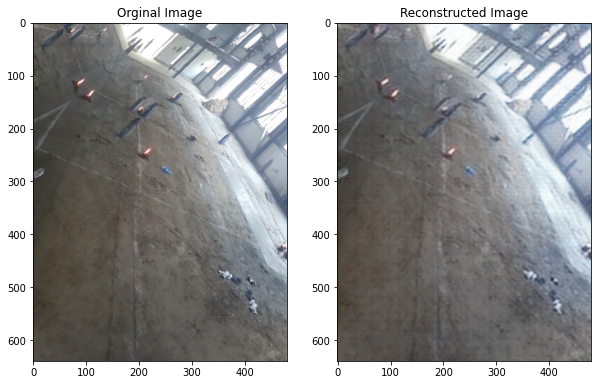

In [ ]:
sample_compare_plot(11)

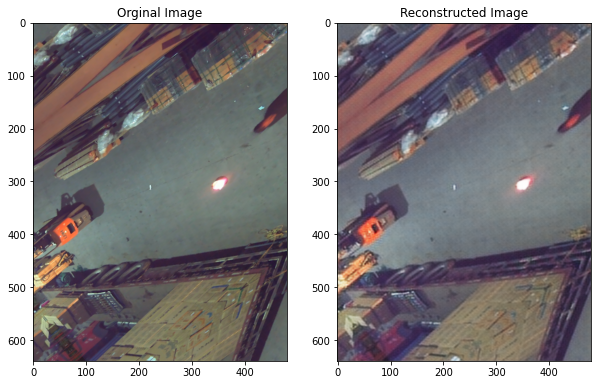

In [ ]:
sample_compare_plot(5)

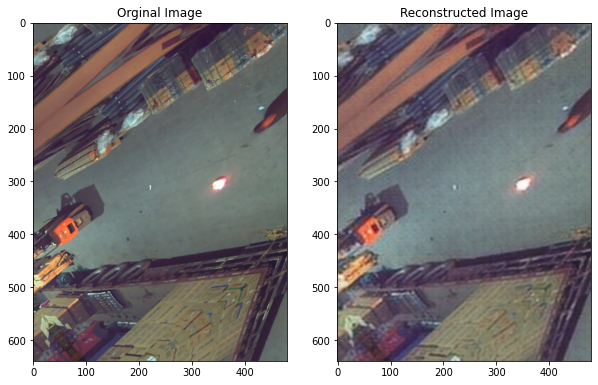

In [ ]:
sample_compare_plot(5)

# Train another model for other fire images

In [ ]:
fire_path = data_dir/'fire'
train_fire = tf.keras.preprocessing.image_dataset_from_directory(
  fire_path, 
  seed=123, label_mode =None,
  image_size=(img_height, img_width),
  batch_size = batch_size, validation_split = 0.2, subset = 'training'
  ).map(lambda x : data_augmentation(x/255.) ).cache().prefetch(2)
train_size = train_ds.cardinality().numpy()
print('Train batches', train_size)


test_fire = tf.keras.preprocessing.image_dataset_from_directory(
  fire_path, 
  seed=123, label_mode = None,
  image_size=(img_height, img_width),
  batch_size = batch_size, validation_split = 0.2, subset = 'validation', 
  ).map(lambda x: data_augmentation(x/255.) ).cache().prefetch(2)
test_size = test_ds.cardinality().numpy()
print('Test batches', test_size)

Found 1232 files belonging to 6 classes.
Using 986 files for training.
Train batches 62
Found 1232 files belonging to 6 classes.
Using 246 files for validation.
Test batches 16


In [ ]:
fire_encoder = AUTOENCODER()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
fire_encoder.compile(loss=losses.MSE, optimizer=optimizer)
earlystopping = keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

In [ ]:
fire_data = np.stack(list(train_fire.unbatch()))
print('Training data shape:', fire_data.shape)

Training data shape: (986, 640, 480, 3)


In [ ]:
fire_encoder.fit(fire_data, fire_data, epochs=150, callbacks=earlystopping, batch_size=64)

Epoch 1/150
16/16 [==============================] - 23s 371ms/step - loss: 0.0674
Epoch 2/150
16/16 [==============================] - 6s 345ms/step - loss: 0.0361
Epoch 3/150
16/16 [==============================] - 6s 350ms/step - loss: 0.0220
Epoch 4/150
16/16 [==============================] - 6s 347ms/step - loss: 0.0157
Epoch 5/150
16/16 [==============================] - 5s 338ms/step - loss: 0.0133
Epoch 6/150
16/16 [==============================] - 6s 351ms/step - loss: 0.0121
Epoch 7/150
16/16 [==============================] - 6s 346ms/step - loss: 0.0110
Epoch 8/150
16/16 [==============================] - 6s 347ms/step - loss: 0.0106
Epoch 9/150
16/16 [==============================] - 6s 344ms/step - loss: 0.0101
Epoch 10/150
16/16 [==============================] - 6s 346ms/step - loss: 0.0098
Epoch 11/150
16/16 [==============================] - 6s 344ms/step - loss: 0.0094
Epoch 12/150
16/16 [==============================] - 6s 350ms/step - loss: 0.0093
Epoch 13/150

In [ ]:
sample = np.stack(list(train_fire.take(1))).squeeze()

In [ ]:
decoded_sample = fire_encoder.predict(sample)

In [ ]:
def sample_compare_plot(random_image, sample=sample,decoded_sample=decoded_sample):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
  ax1.imshow(sample[random_image].squeeze())
  ax1.set_title('Orginal Image')
  ax2.imshow(decoded_sample[random_image].squeeze())
  ax2.set_title('Reconstructed Image')
  plt.show()

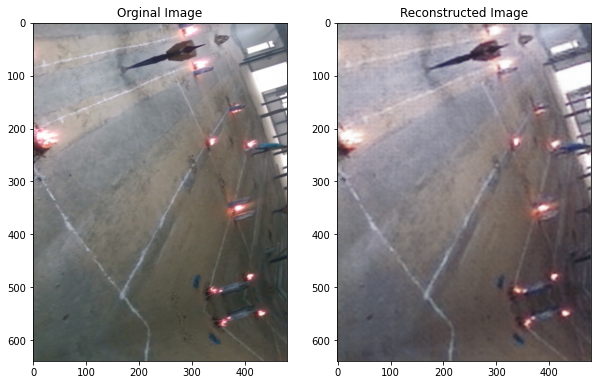

In [ ]:
sample_compare_plot(20)

In [ ]:
fire_only_model_path = fire_encoder_path + '/fire_only_model'
fire_only_model_path

'/content/drive/MyDrive/Colab Notebooks/CS767_project/fire_only_model'

In [ ]:
# save model
fire_encoder.save(fire_only_model_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/CS767_project/fire_only_model/assets
